# Exploratory analysis of Bayesian models

# Imports

In [13]:
%config InlineBackend.figure_format="retina"

In [37]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy import stats

## Life after inference

## Understanding your assumptions

**Prior predictive checks**
are computing a prior predictive distribution by sampling from the model
without taking into account the data.
This can be used to understand affects of choices of priors.

If priors give bad values:

- Rethinkg model
- Use prior that reduces invalid results
- See if data is informative enough to exclude nonsensical values

For example a logistic regression
can favor more and more extreme values
as the number of predictors increases.
A strong regularizing prior—like
the Laplace distribution—
can keep model away from extreme values.


### Understanding your predictions

**Posterior predictive checks**
evaluate how close the synthetic observations are
to the actual observations.

Can plot them againt each other to visially inspect,
or use Baeysian p-value—probability
that simulated test statistic $T_{sim}$
is less or equal than the observed statistic $T_{obs}$.
Usually the ideal value is $p_{B} = 0.5$—half
the time it's below,
and the other half above.

$$
p_{B} = p(T_{sim} \leq T_{obs} \mid \tilde Y)
$$

Can plot with `az.plot_bpv(..., kind="p_value")`.

Arviz funcitons for plots:

- **`az.plot_ppc(..)`**
  plots generated model data vs actual data
- **`az.plot_bpv(..., kind="p_values")`**
  plots the proportion of predicted values
  that are less than or equal to the observed data (p-value)
  compared to the expected distribution for a dataset of the same size
  as the observed data
- **`az.plot_bpv(..., kind="u_values")`**
  plots the proportion of predicted values that are less or equal than the observed per observation.
  Ideal case is white line—a uniform distribution.
  Grey band is where we expect to see 94% of Uniform-like curves,
  even good models have deviations from a perfect Uniform.

![Posterior check plots](images/chapter_2/posterior_predictive_many_examples.png)


## Diagnosing numerical inference

Bad chains:

- Are not independent,
  and show correlation
- Are not identically distributed
- Have some regions that are not sampled well

In [10]:
rng = np.random.default_rng(42)
good_chains = stats.beta.rvs(2, 5, size=(2, 2000))
bad_chains0 = rng.normal(
    np.sort(good_chains, axis=None), 0.05, size=4000
).reshape(2, -1)  # Values not independent and identically distributed

# Portions have high correlation
bad_chains1 = good_chains.copy()
for i in rng.integers(1900, size=4):
    bad_chains1[i % 2 :, i : i + 100] = rng.beta(i, 950, size=100)

chains = {
    "good_chains": good_chains,
    "bad_chains0": bad_chains0,
    "bad_chains1": bad_chains1,
}

### Effective sample size

Samples from MCMC methods are **autocorrelated**—there
is a similarrity between values as a function of the time lag between them—and
the amount of information contained in the sample
is less than what one would get from an iid sample
of the same size.

**Effective Sample Size (ESS)**
is an estimator
that takes autocorrelation into account
and provides the numers of draws we would have
if our sample was iid.

In [11]:
az.ess(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 4.065e+03
    bad_chains0  float64 2.436
    bad_chains1  float64 2.253e+03

`az.ess` returns `bulk-ESS` by default—which
assesses how the center of the distribution
is resolved.
`tail-ESS` corresponds to
5 and 95 percentiles.
`az.ess(..., method="quantile")`
for specific quantiles.

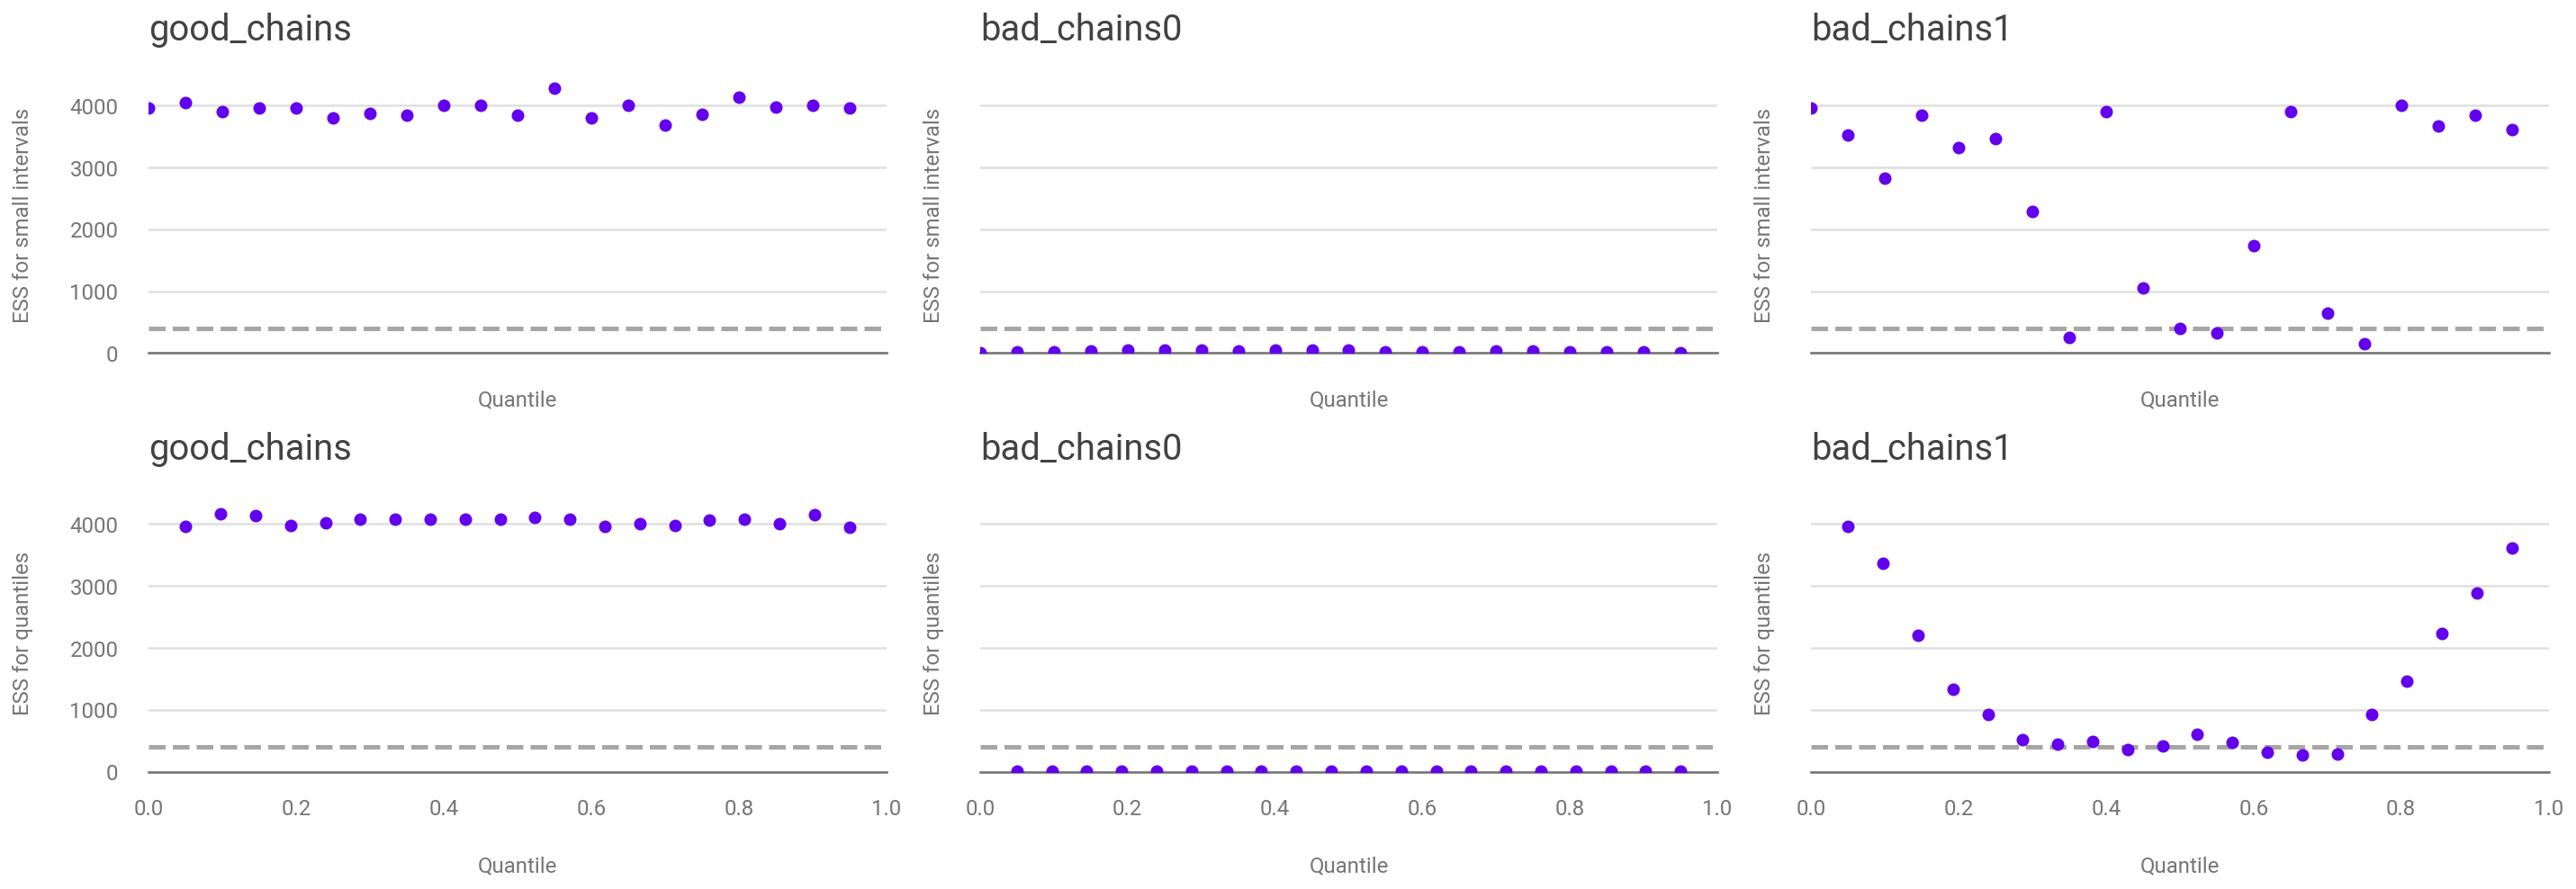

In [19]:
_, (top_ax, bottom_ax) = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(20, 7))
az.plot_ess(chains, kind="local", ax=top_ax)  # Small intervals between 2 quantiles
az.plot_ess(chains, kind="quantile", ax=bottom_ax)
plt.tight_layout();

In plots above,
dashed line represents
the minimum suggested value for sufficient sample size—400.

### Potential scale reduction factor $\hat R$

MCMC will converge eventually,
but need to test if it converged now.
Can run multiple chains
and see if they look similar.
**$\hat R$**
is a numerical reprentation of this idea—it
is the standard deviation of all samples of $\theta$
divided by the root mean quare of the seperated within-chain standard deviations.
Ideal value is 1—
variance between chains should be the same
as variance within-chain.
Practically $\hat R \lessapprox 1.01$  is okay.

In [20]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 1.0
    bad_chains0  float64 2.409
    bad_chains1  float64 1.013

### Monte carlo standard error

MCMC methods introduce an additional layer of uncertainty
as we approximate the posterior with a finite number of samples.
**Monte Carlo standard error (MCSE)**
takes into account that the samples
are not truly independent of each other.
MCSEE required domain expertise.
If we want to report a value of an estimated parameter to the second decimal,
MCSE must be below that second decimal.
Check MCSE after checking
that ESS is high enough
and $\hat R$ is low enough.

In [21]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002497
    bad_chains0  float64 0.1079
    bad_chains1  float64 0.002961

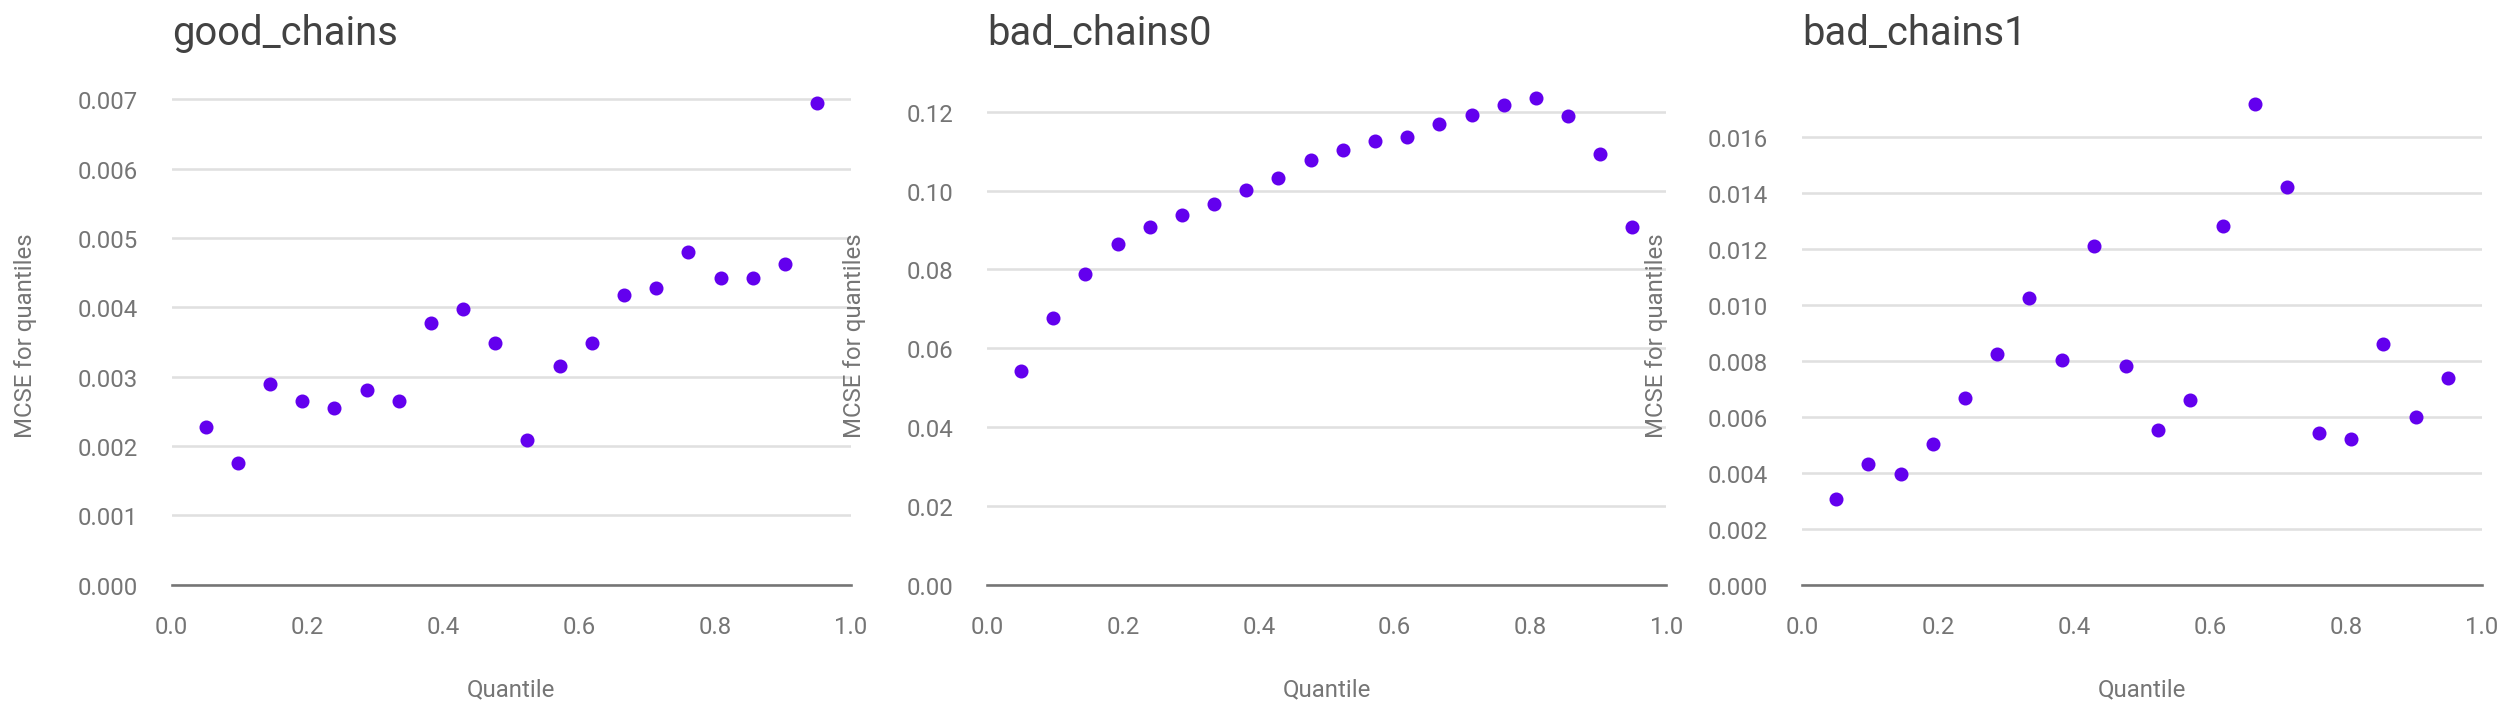

In [23]:
az.plot_mcse(chains);

Ideally we want MCSE to be small across all regions of the parameter space.

In [25]:
az.summary(chains, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.002,0.002,4065.0,3954.0,1.00
bad_chains0,0.108,0.088,2.0,11.0,2.41
bad_chains1,0.003,0.002,2253.0,3609.0,1.01


### Trace plots

**Trace plots** are often the first plot you make after inference.
Draws the sampled values at each iteration step.
Check if different chains
converge to the same distributuion.
Check autocorrelation.

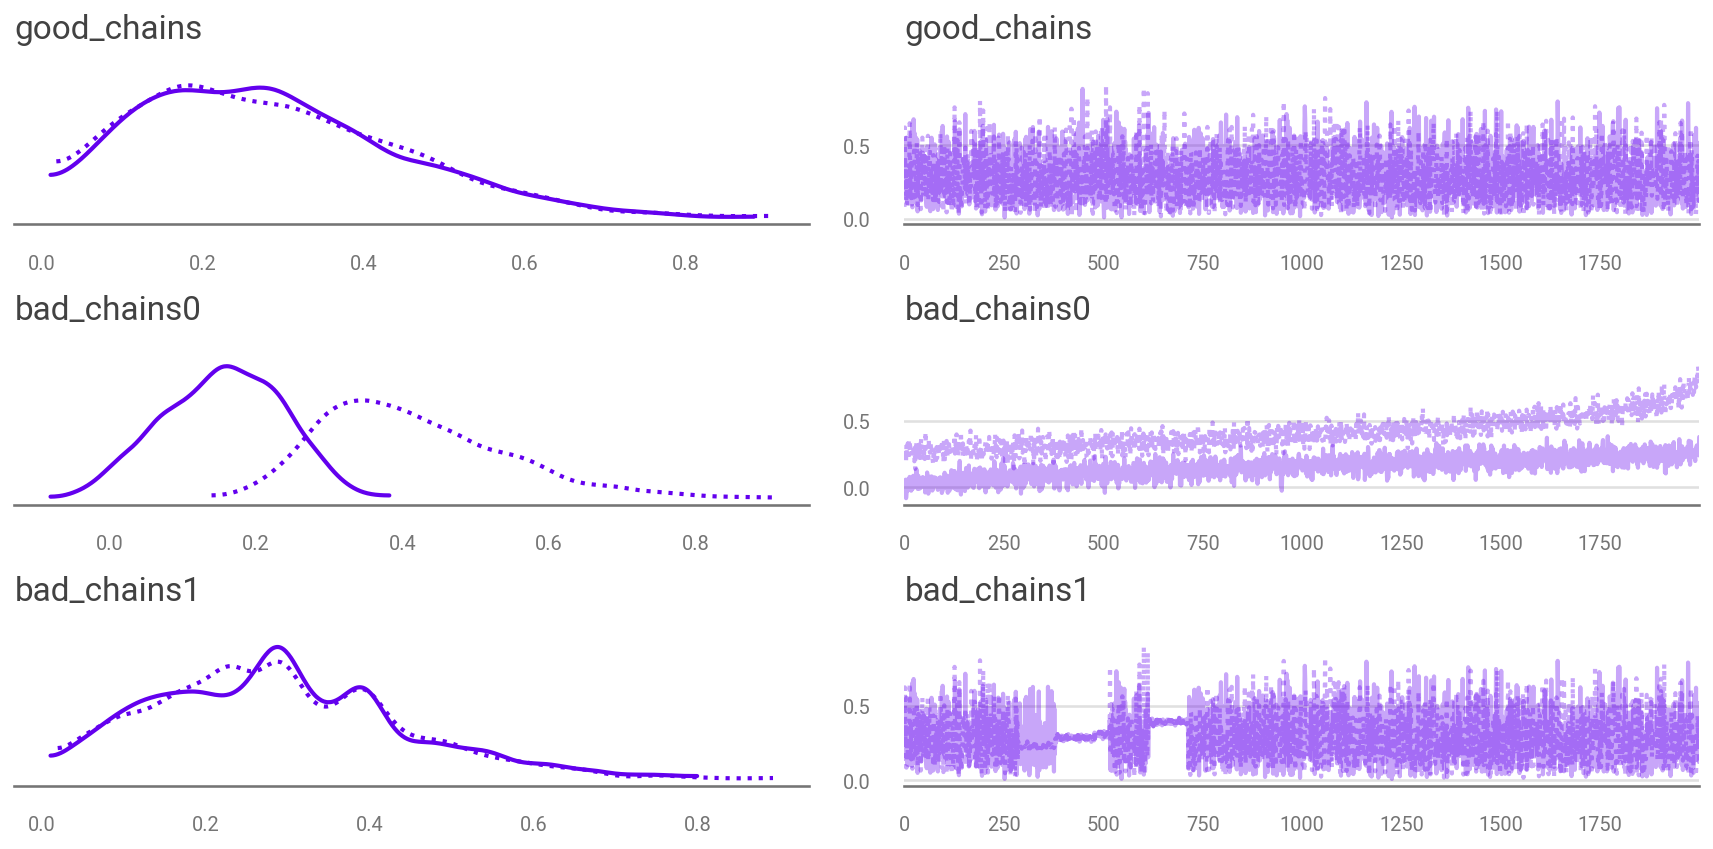

In [28]:
az.plot_trace(chains)
plt.tight_layout();

Left column:
one KDE per chain.
Right column:
sampled values per chain per step.

Good chains have only small differences between distributions,
and ordered values should have no pattern,
and be difficult to distinguish chains from each other.
Random peaks that are inconsistent from trace to trace—like
`bad_chains1`—are
suspicious.

### Autocorrelation plots

Autocorrelation decreases the actual amount of information in a sample.

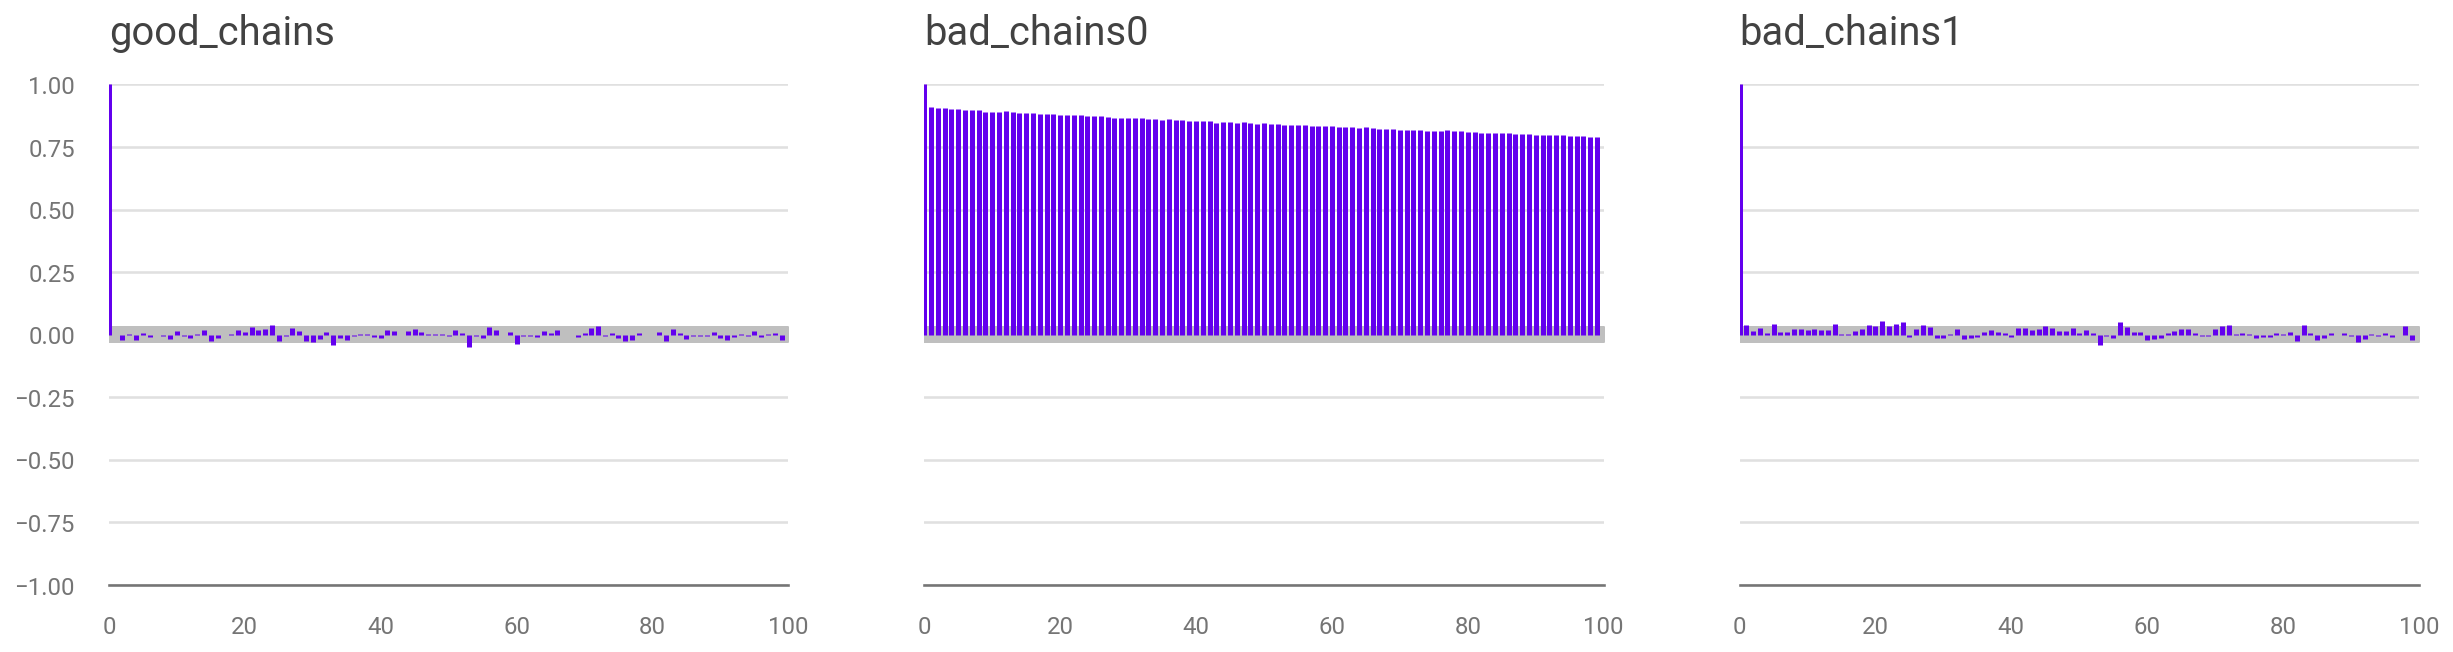

In [31]:
az.plot_autocorr(chains, combined=True);

### Rank plots




**Rank plots**
are histograms of the ranked samples.
Ranks are computed for all chains,
but plots are per chain.
If all chains are targeting the same distribution,
we expect a Uniform distribution.

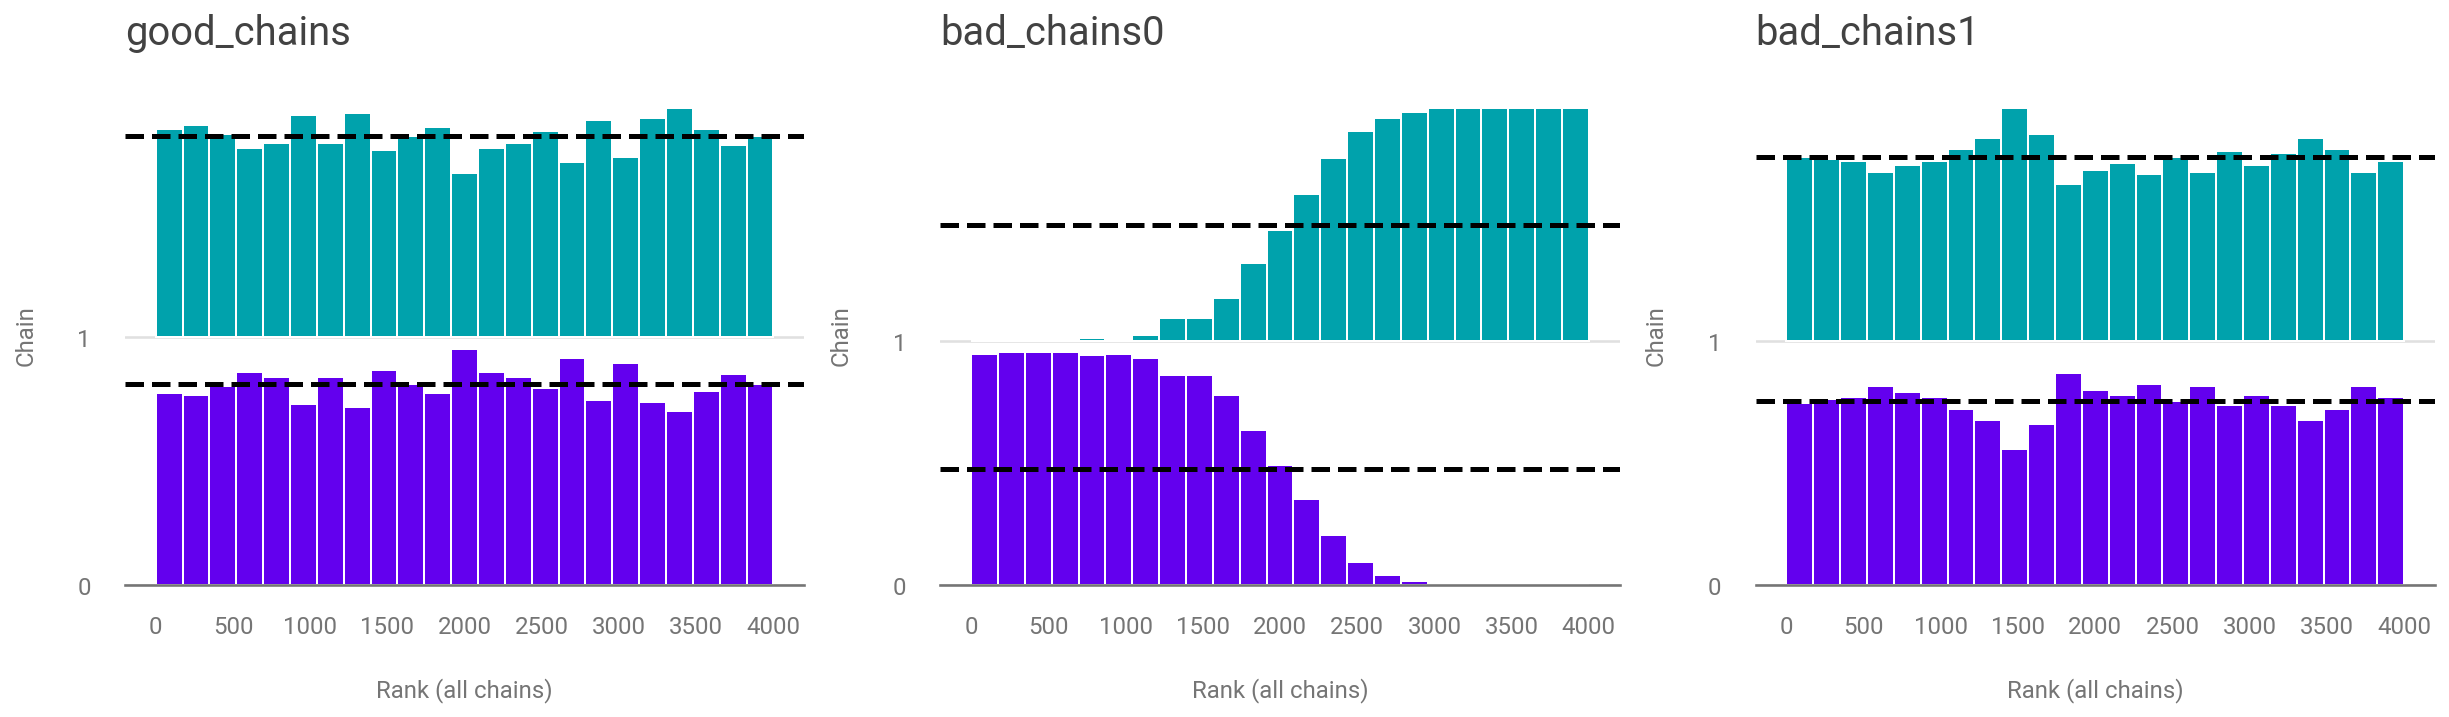

In [33]:
az.plot_rank(chains, kind="bars");

Can also plot vertical lines.
Vertical lines above the dashed line
indicate an exces sample value.
Below the line is a lack of sampled values.
The shorter the line,
the better.

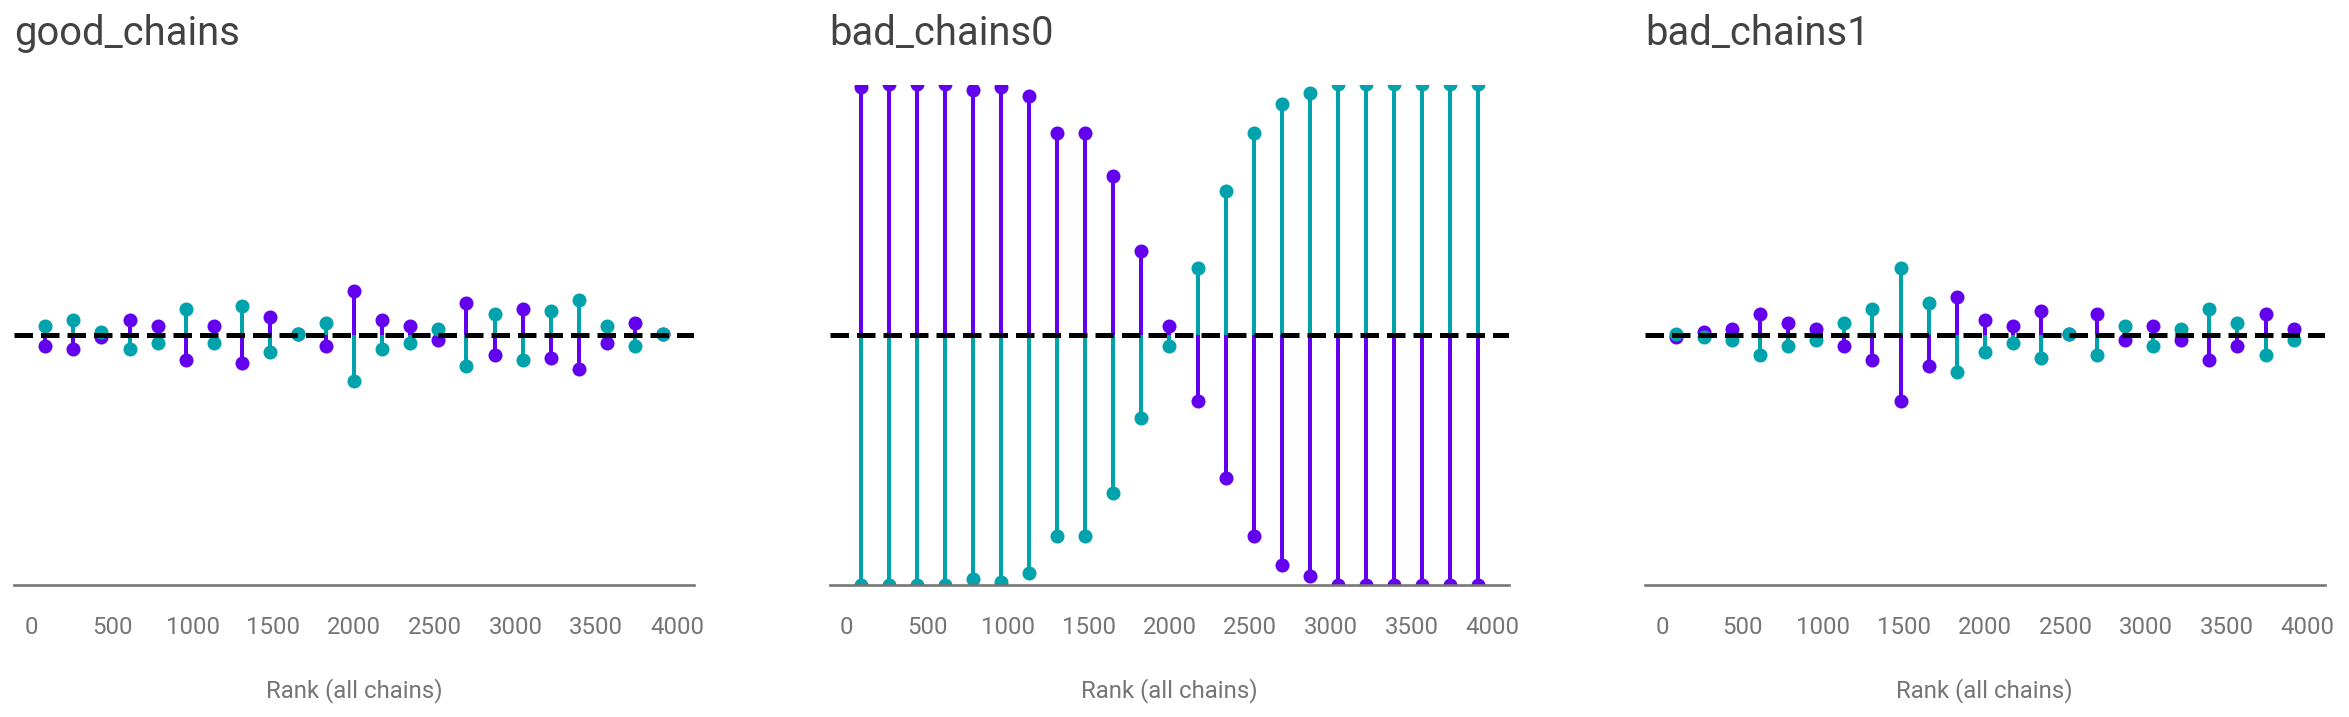

In [36]:
az.plot_rank(chains, kind="vlines");

Rank plots are more sensitive thatn trace plots.
`az.plot_trace(..., kind="rank_bars")` or `az.plot_trace(..., kind="rank_vlines")`.

### Divergences

Besides studying the generated samples,
can also monitor the innner workings
of the sampling method.



In [40]:
with pm.Model() as model_0:
    θ1 = pm.Normal("θ1", 0, 1, testval=0.1)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_0 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1:
    θ1 = pm.HalfNormal("θ1", 1 / (1 - 2 / np.pi) ** 0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1bis:
    θ1 = pm.HalfNormal("θ1", 1 / (1 - 2 / np.pi) ** 0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1bis = pm.sample(target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 640 divergences after tuning. Increase `target_accept` or reparameterize.
There were 512 divergences after tuning. Increase `target_accept` or reparameterize.
There were 538 divergences after tuning. Increase `target_accept` or reparameterize.
There were 522 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.9024369396387094, but should be close to 0.95. Try to increase the number of tuning steps.


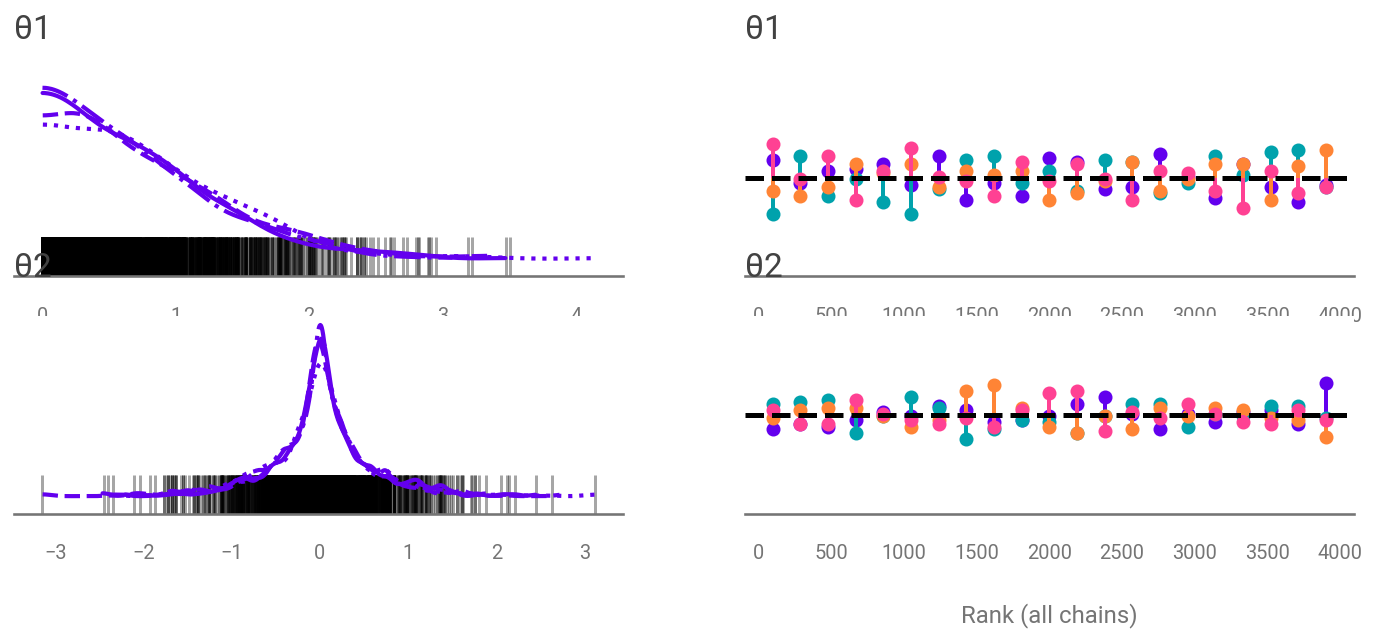

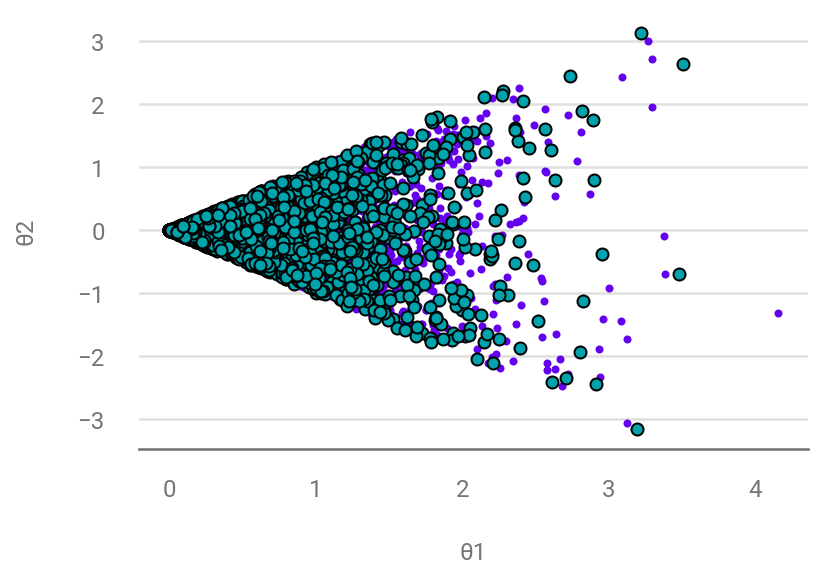

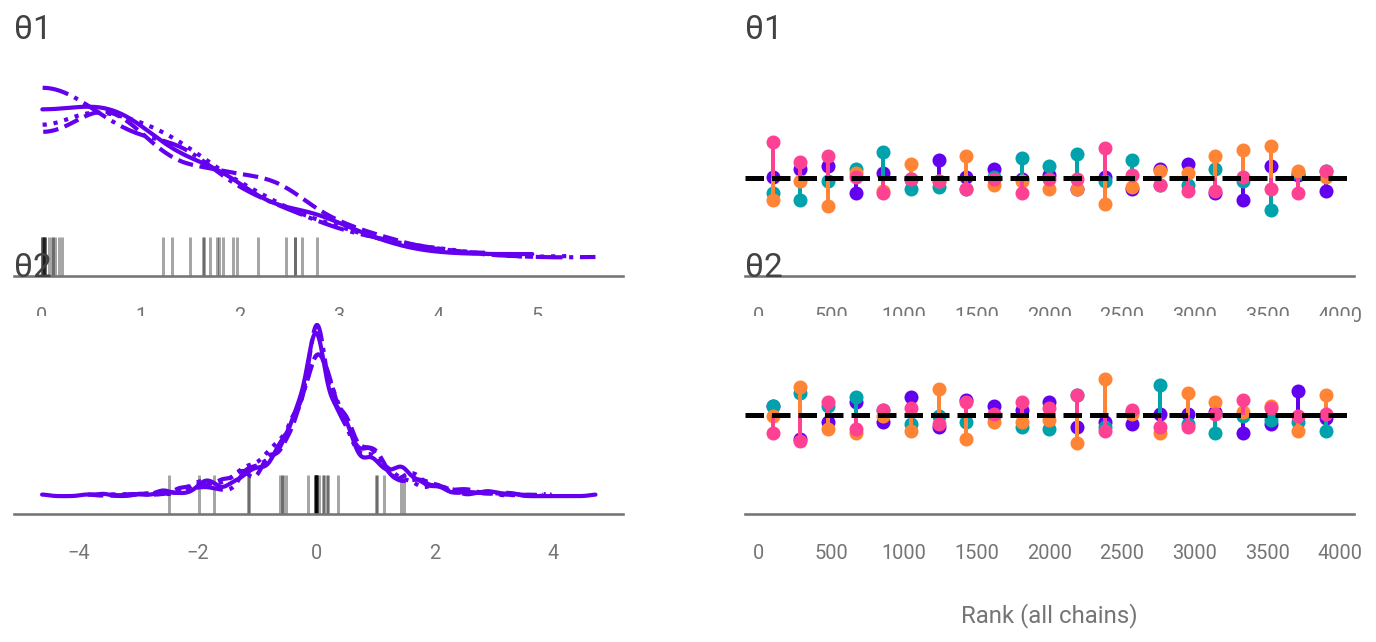

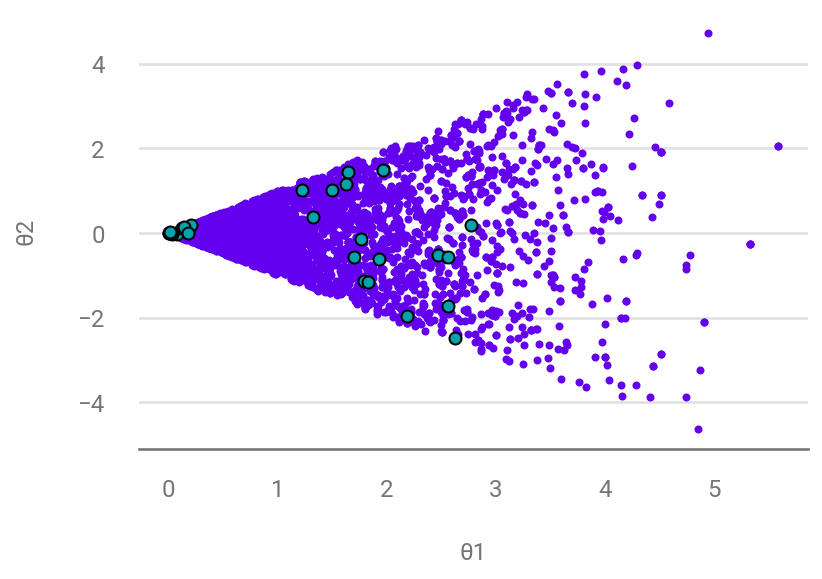

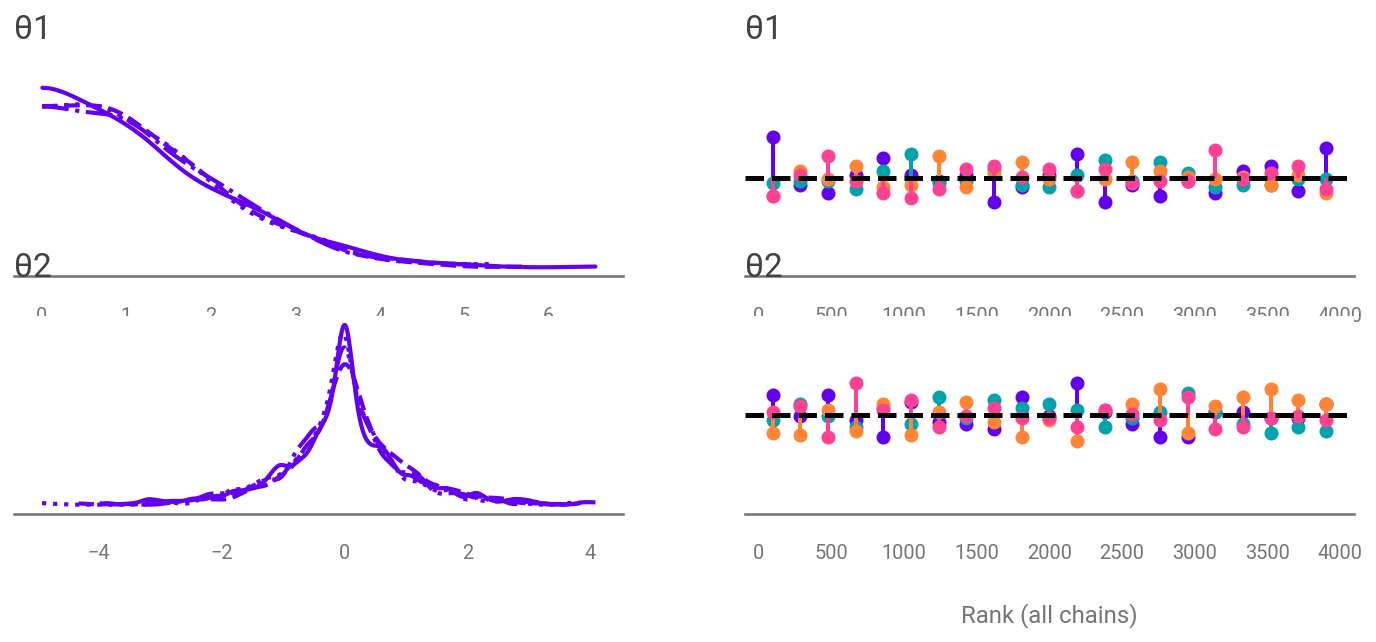

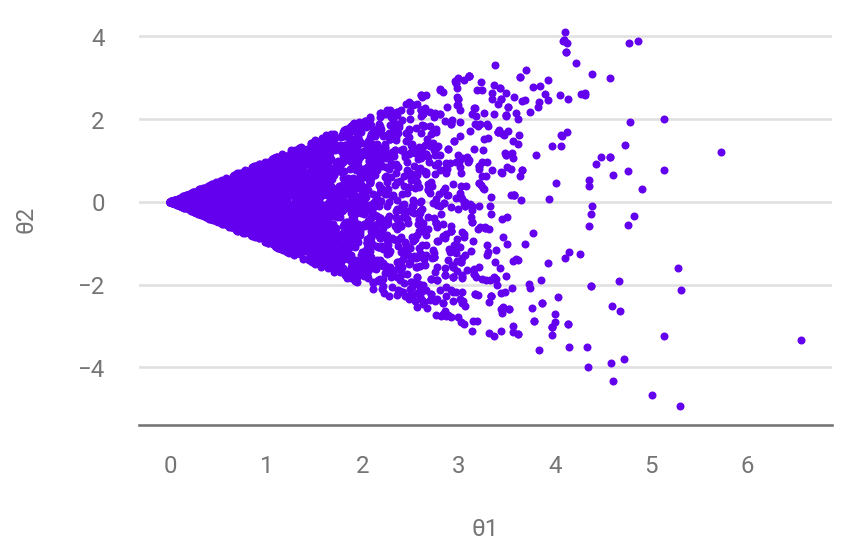

In [52]:
for i, idata in enumerate([idata_0, idata_1, idata_1bis]):
    az.plot_trace(idata, kind="rank_vlines")
    az.plot_pair(idata, divergences=True)
plt.tight_layout();

Each of the vertical bars represents a divergence in the trace plots,
and in the pair plots they are the teal points.

`model_0` has $\theta1$ as a Normal centered at 0,
which is negative half the time.
`model_1` tries to reparamaterize.
`model_1bis` increases `target_accept`
and looks good,
but need to check ESS and $\hat R$
to be sure.

### Sampler parameters and other diagnostics

Solutions:

- Increase `target_accept`
  if divergences originate from numerical imprecision.
- Increase `tune`—which
  further adjusts the sampler parameters—can
  help to increase ESS or lower $\hat R$
- Increase the number of draws can help with convergence—but
  is the least productive solution.
- Reparameterizxation
- Improve model structue
- More informative priors
- Change model

Samples:

- Use 200–300 samples for testing
- Use 2,000–4,000 when more comfertable

Additional diagnostics:

- Parellel plots
- Seperation plots

## Model comparison

Can compare models using generalization error,
or out-of-sample predictive accuracy—and
estimate of how well a model behaves at predicting data
not used to fit it.

One generic metric is the logrithmic scoring rule—the
**expected log pointwise predictive density (ELPD)**.

$$
\text{ELPD} = \sum_{i=1}^{n} \int p_t(\tilde y_i) \; \log p(\tilde y_i \mid y_i) \; d\tilde y_i
$$

where $p_t(\tilde y_i)$ is the distribution of the true data-generating process for $\tilde y_i$
and $p(\tilde y_i \mid y_i)$ is the posterior predictive distribution.

For real problems we do not know $p_t(\tilde y_i)$,
so we can use the deviance:

$$
\sum_{i=1}^{n} \log \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y) d\boldsymbol{\theta}
$$

To compute this
we use the same data used to fit the model,
and on average overestimate the ELPD—which
leads to overfitting.
Cross-validation helps alleviate this problem.

### Cross-validation and LOO

**Cross-validation (CV)**
is estimateing out-of-sample predictive accuracy.
You re-fit the model many times,
each time excluding a different portion of the data.
The excluded portion is used to measure the accuracy of the model.
This is repeated many times
and the results are averaged over the runs.

$$
\text{ELPD}_\text{LOO-CV} = \sum_{i=1}^{n} \log
    \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y_{-i}) d\boldsymbol{\theta}
$$

In practive we don't know $\boldsymbol{\theta}$ 
and need to compute $n$ posteriors.
This is expensice,
and we can approximate $\text{ELPD}_\text{LOO-CV}$
from a single fit to the data
by using Pareto smoothed importance sampling leave-one-out cross validation PSIS-LOO-CV—or
just LOO.

In [63]:
rng = np.random.default_rng(42)
y_obs = rng.normal(0, 1, size=100)
idatas_cmp = {}

# Generate data from Skewnormal likelihood model
# with fixed mean and skewness and random standard deviation
with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", 0, σ, alpha=1, observed=y_obs)
    # This pattern is likely to change in PyMC 4.0
    trace_A = pm.sample(return_inferencedata=False)
    posterior_predictive_A = pm.sample_posterior_predictive(trace_A)
    idataA = az.from_pymc3(
        trace=trace_A,
        posterior_predictive=posterior_predictive_A,
    )
idatas_cmp["mA"] = idataA

# Generate data from Normal likelihood model
# with fixed mean with random standard deviation
with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    trace_B = pm.sample(return_inferencedata=False)
    posterior_predictive_B = pm.sample_posterior_predictive(trace_B)
    idataB = az.from_pymc3(
        trace=trace_B,
        posterior_predictive=posterior_predictive_B
    )
idatas_cmp["mB"] = idataB

# Generate data from Normal likelihood model
# with random mean and random standard deviation
with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    trace_C = pm.sample(return_inferencedata=False)
    posterior_predictive_C = pm.sample_posterior_predictive(trace_B)
    idataC = az.from_pymc3(
        trace=trace_C,
        posterior_predictive=posterior_predictive_C,
    )
idatas_cmp["mC"] = idataC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [64]:
az.loo(idataA)

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -146.26    10.05
p_loo        1.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [68]:
compare_df = az.compare(idatas_cmp)
compare_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
mB,0,-117.287453,0.884273,0.000000,1.000000e+00,6.747472,0.000000,False,log
mC,1,-118.115842,1.880765,0.828389,1.110223e-16,6.691354,0.665022,False,log
mA,2,-146.262687,1.269918,28.975234,1.110223e-16,10.048119,6.556861,False,log


- `rank`
  Ranks the model from highest predictive accuracy
- `loo`
  lists ELPD values
- `p_loo`
  list values for the penalization term.
  This is kinda the estaimted effective number of parameteres,
  it can be lower than the actual number of parameters
  when model has more structure—
  like a hierarchical model—or
  can be much higher when the model has weak predictive capability
  and may indicate misspecification for model.
- `d_loo`
  list of relative differences
  between the value of LOO
  for the top and current model.
- `weight`
  is the weight for each model—the
  probability of each model given the data
  among other compared models
- `se`
  The standard error for the ELPD
- `dse`
  The standard errors of the differences between two values
  of the ELPD.
  `dse` is not necessarity the same as `se`,
  because the uncertaintly about the ELPD can be correlated between models.
  dse is always 0 for top rank models.
- `warning`
  if LOO may not be reliable.
- `loo_scale`
  is the scale of reported values.
  Default is log scale.

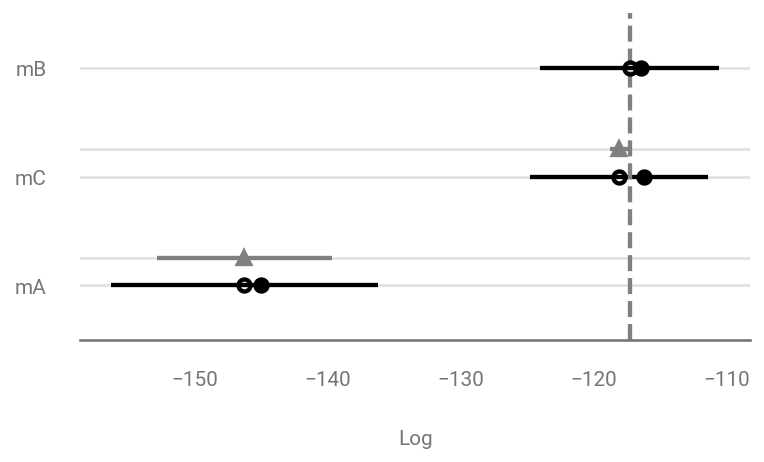

In [69]:
az.plot_compare(compare_df);

Can plot as well.
Where open circle is `loo`,
black dots are predictive accuracy without `p_loo`,
Black segments are error for LOO (`se`),
and grey segments are erorrs of the difference `dse`
between LOO value and best ranked value.

`mA` is worst,
but `mB` and `mC` are close.
Rule of thumb—LOO difference below 4 is small.
Difference is that `mB` the mean is fixed at 0,
and `mC` it has a prior—which
results in a penalty.
This is why `p_loo` is larger for `mC`,
and black dot on plot
(unpenalized ELPD)
and open dot
($\text{ELPD}_\text{LOO-CV}$)
is larger as well.
`dse` is also lower
than respective `se`—indicating
correlation.

### Expected log predictive density

Previouly we looked at LOO for entire model,
but can also do local comparisons.

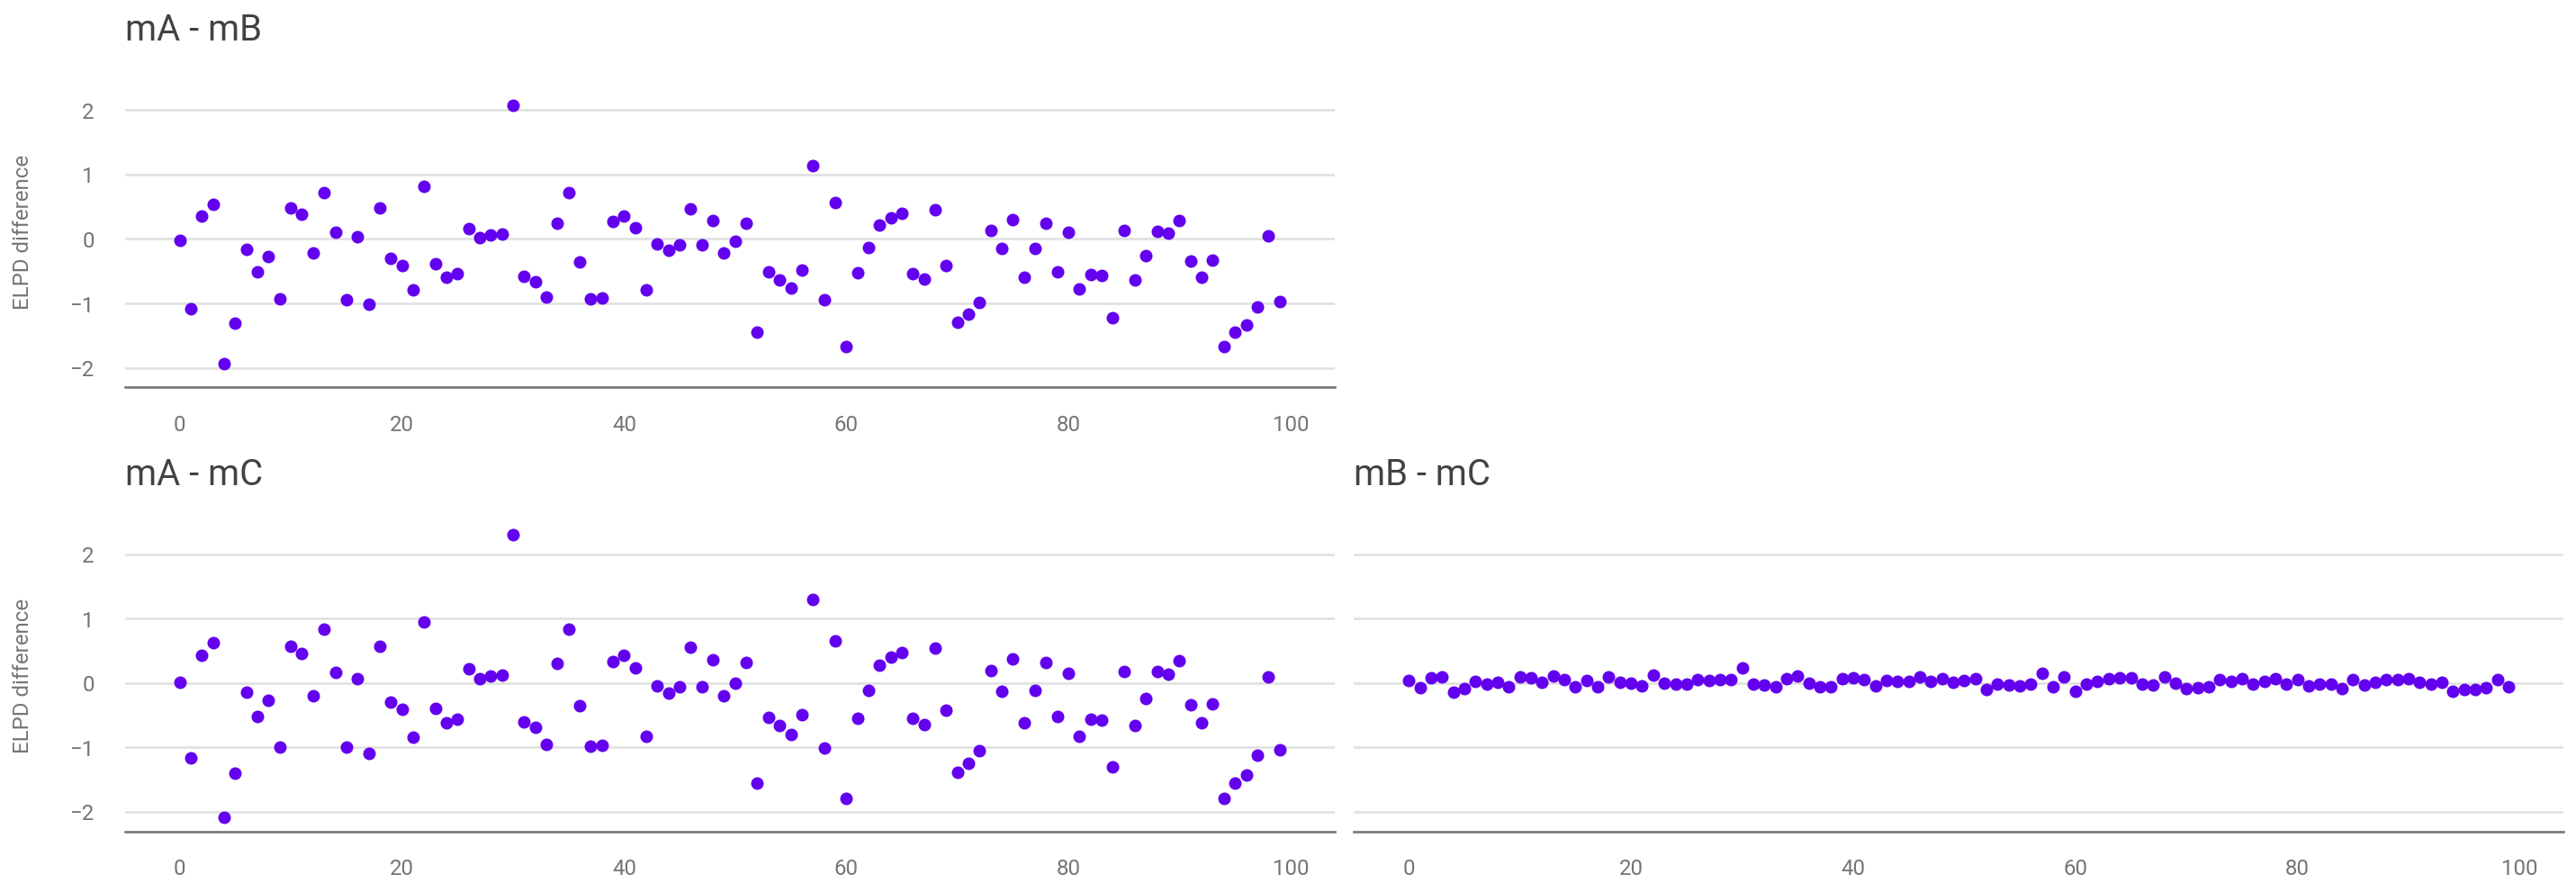

In [76]:
_, axes = plt.subplots(2, 2, figsize=(20, 7), sharey=True)
az.plot_elpd(idatas_cmp, ax=axes)
plt.tight_layout();

Positive values are when observations are better resolved by the first model than the second.

### Pareto shape parameter

LOO approximation involves coputing a Pareto distribution.
Main purpose is to get a robust estimation,
but side-effect is that it can be used to detect
highliy influential observations—
observatoins that would change the model if left out.
Higher values of $\hat \kappa$
can indicate problems with the data of model—especially
when 0.7 < $\hat \kappa$.
If this is the case:

- Use matching moment method.
  Transform MCMC draws from the posterior distirubtion
  to obtain a more reliable importance sample
- Perform exact leave-one-out cross validation
  for problematic observations
  or use k-fold
- Use a model that is more robust to anomalies

`az.loo` and `az.compare` will give warning in `warning` column if 0.7 < $\hat \kappa$.

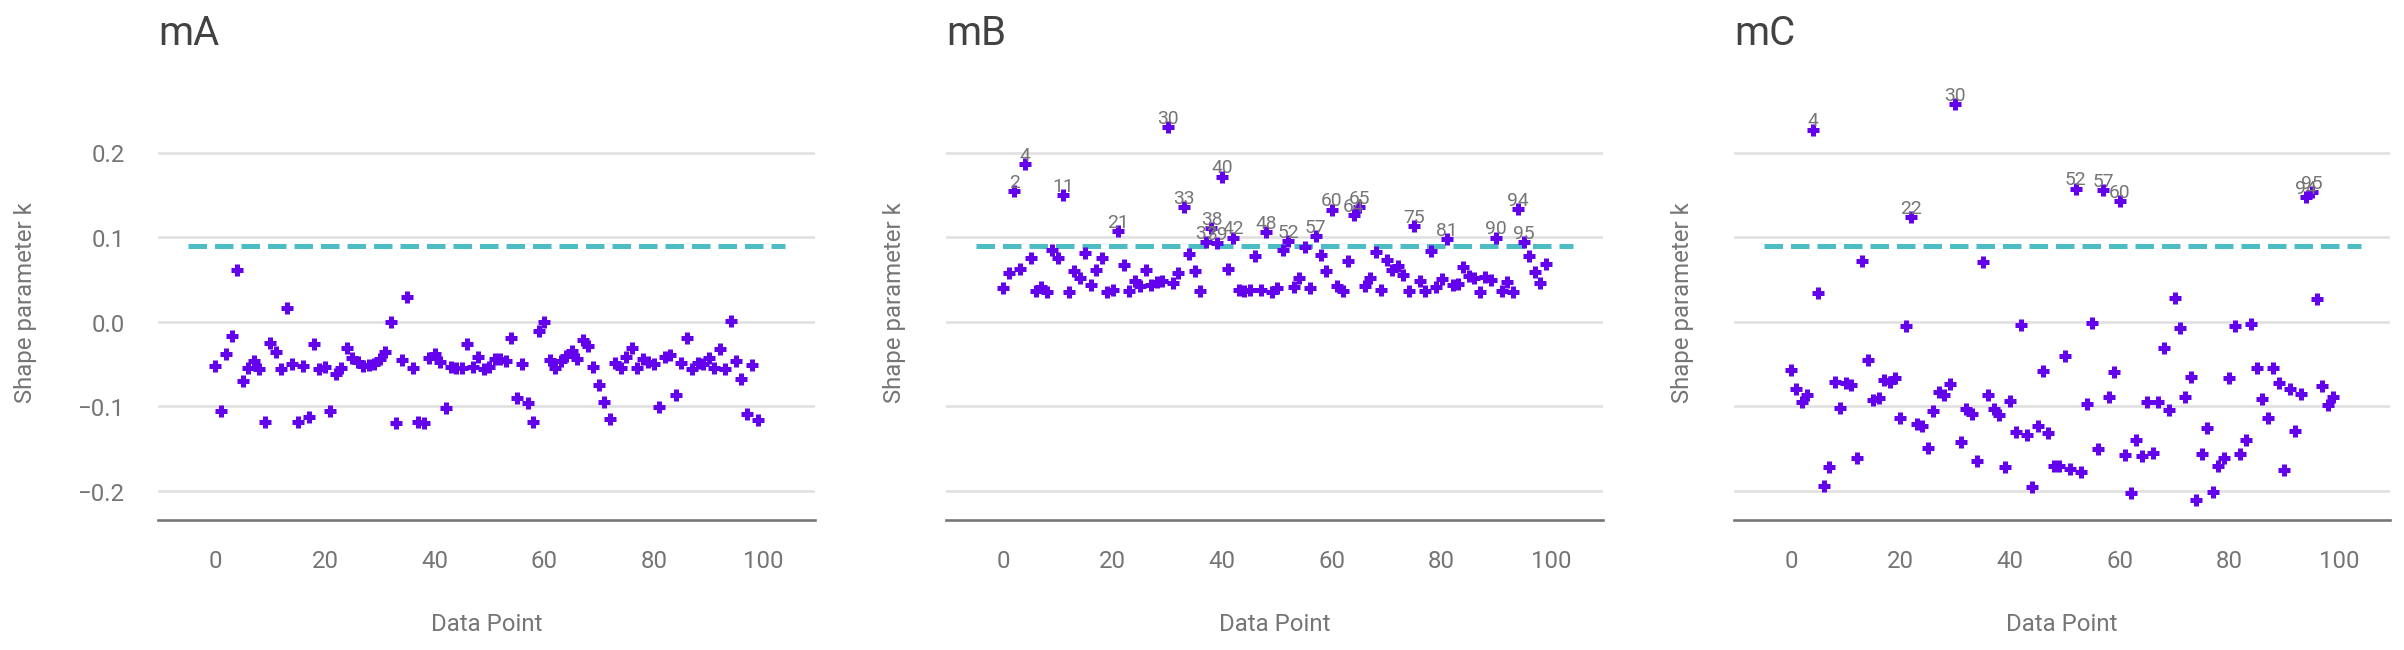

In [80]:
_, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
for model, ax in zip(idatas_cmp, axes):
    loo = az.loo(idatas_cmp[model], pointwise=True)
    az.plot_khat(
        loo,
        ax=ax,
        threshold=0.09,
        show_hlines=True,
        hlines_kwargs={"hlines": 0.09, "ls": "--"},
    )
    ax.set_title(model)

In above plot 0.09 is chosen as arbitrary point.

### Interpreting `p_loo` when Pareto $\hat \kappa$ is large

`p_loo` is kinda like the estimated effective number of parameters.
For models with large $\hat \kappa$ (> 0.7) we can get some extra information.

- If `p_loo` << $p$,
  the model is likely misspecified.
  You usually see problems in the posterior predictive checks
  not matching with data.
- If `p_loo` << $p$
  and $p$ is relatively large compared to the number of observations—like
  $p > \frac{N}{5}$
  (where $N$ is total observations).
  Usually indication that the model is too flexible,
  or priors too uniformative,
  so it's difficult to predict the left out observations.
- If `p_loo` > $p$,
  then the model is likely to be badly misspecified.
  If the number of parameters is $p << N$,
  then the posteior predictive checks might reveal a problem.
  If $p$ is relatively large copmpared to the nmber of observations—like
  above—you
  might not see problems in posterior predictive checks.

If model misspecification,
try:

- Add more structure
    - E.g. Nonlinear components
- Use different likelihood
    - Overdispered likelihood
        - E.g. NegativeBinomial instead of Poisson
    - Mixture likelihood

### LOO-PIT

For posterior predictive checks the data is used twice—once
to fit the model
and again to check it.
LOO-PIT (Probability Integral Transform) tries to remedy this.
Can use LOO as a fast approximation to cross-validation.
For a well calibrated model,
we should expect an approximatley Uniform distribution.
This is similar to [Understanding your predictions](#understanding-your-predictions).

LOO-PIT is obtained by comparing the observed data $y$
to the posterior predicted data $\tilde y$.
It's computing the probability that the posterior predicted data $\tilde y_i$
has lower value than the observed data $y_i$,
when we remove the $i$ observation.

The difference between `az.plot_bpv(idata, kind="u_value")` and LOO-PIT
is that with the latter we are approximately avoiding using the data twice
but the overall interpretation of the plots is the same.

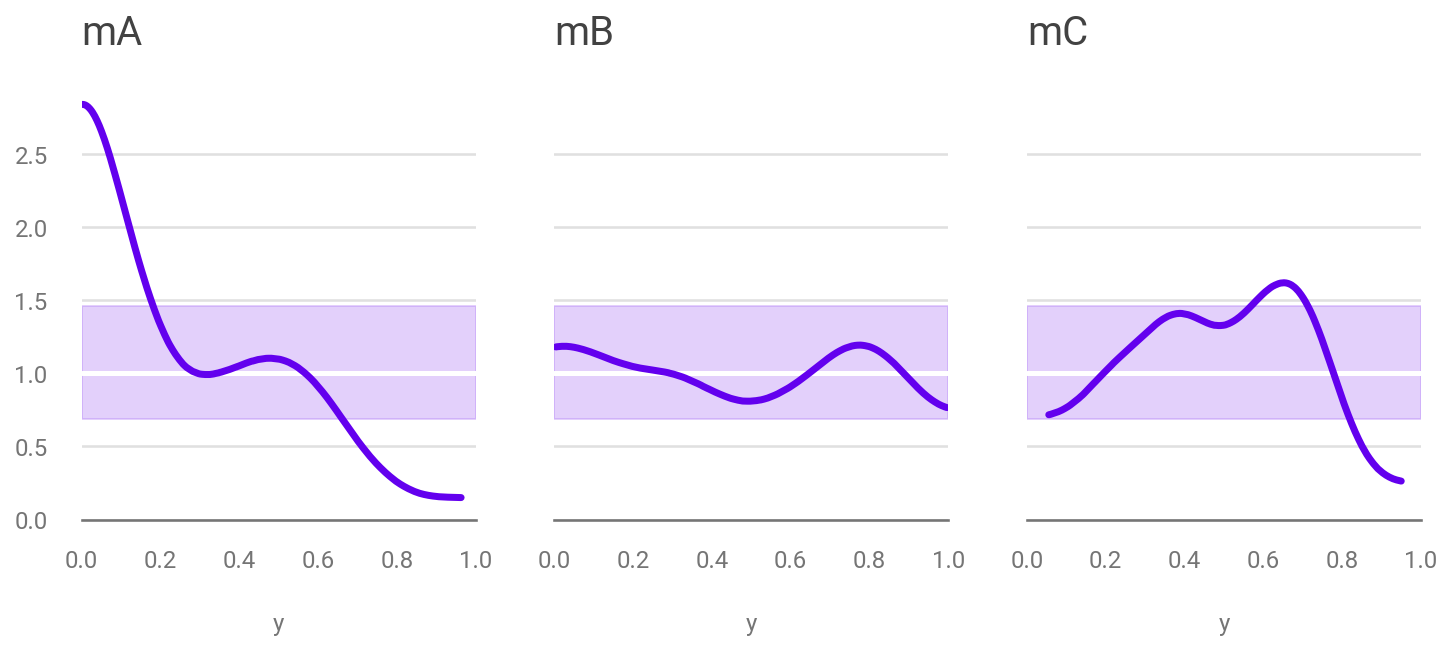

In [85]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for model, ax in zip(("mA", "mB", "mC"), axes):
    az.plot_loo_pit(idatas_cmp[model], y="y", legend=False, use_hdi=True, ax=ax)
    ax.set_title(model)

### Model averaging

If we are not sure that our model is the definitive model,
we can take that uncertainty into account for our analysis.
One way is to perform a weighted average
over all considered models—with
more weight given to models that explain or predict model better.

**Bayesian model averaging** is weighing models by ther marginal likelihoods.
It's hard in practive,
so we can use LOO to estimate weights.

$$
w_i = \frac {e^{-\Delta_i }} {\sum_j^k e^{-\Delta_j }}
$$

Where—assuming
we are using the log-scale—$\Delta_i$
is the difference between the $i$ value of LOO and the highest one.
Caveat is that this does not take into account the uncertainty in LOO.
We can compute the standard error assuming a Gaussian
and modify equation,
or use Bayesian Bootstrapping.

Another way to avearge models is stacking their predictive distributions.
You cobine several models to minimize divergence
between model and true model.

$$
\max_{n} \frac{1}{n} \sum_{i=1}^{n}log\sum_{j=1}^{k} w_j p(y_i \mid y_{-i}, M_j)
$$

where $n$ is the number of data points
and $k$ is the number of models.
$p(y_i \mid y_{-i}, M_j)$ is the leave-one-out predictive distribution of model $M_j$—but
it's expensive so we can use LOO.

Even when the models are fittend independently,
the computation of the weights takes into acccount all models together.
This is unlike the model averaging—where
it normalizes weights that are computed independently.
This is why  `az.compare` data above gives `mB` a weight of 1 and `mC` 0—
Once `mB` is included in our set of models,
`mC` doesn't really give us new information.

Weights can be computed from `az.compare(..., method="stacking")
`pm.sample_posterior_predictive_w(...)` accepts a lit of traces and list of weights.